In [11]:
!py -m pip install langgraph-checkpoint-sqlite

# !py -m pip install --upgrade --quiet  langchain langchain-community langchainhub langchain-openai langchain-chroma bs4

  Attempting uninstall: langgraph-checkpoint
    Found existing installation: langgraph-checkpoint 2.0.9
    Uninstalling langgraph-checkpoint-2.0.9:
      Successfully uninstalled langgraph-checkpoint-2.0.9



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
!py -m pip list

Package                                  Version
---------------------------------------- -------------------
absl-py                                  1.0.0
aiohttp                                  3.9.5
aiosignal                                1.3.1
altair                                   5.3.0
annotated-types                          0.6.0
anyio                                    3.5.0
argon2-cffi                              21.3.0
argon2-cffi-bindings                     21.2.0
asgiref                                  3.8.1
asttokens                                2.0.5
astunparse                               1.6.3
async-timeout                            4.0.3
asyncio                                  3.4.3
attrs                                    21.4.0
Babel                                    2.9.1
backcall                                 0.2.0
backoff                                  2.2.1
bcrypt                                   4.1.3
beautifulsoup4                           

opentelemetry-sdk                        1.24.0
opentelemetry-semantic-conventions       0.45b0
opentelemetry-util-http                  0.45b0
opt-einsum                               3.3.0
ordered-set                              4.1.0
orjson                                   3.10.1
overrides                                7.7.0
packaging                                23.2
pandas                                   2.2.3
pandocfilters                            1.5.0
parso                                    0.8.3
pathspec                                 0.9.0
patsy                                    0.5.6
pdf2image                                1.17.0
pickleshare                              0.7.5
pillow                                   10.4.0
pip                                      24.3.1
pipreqs                                  0.5.0
platformdirs                             4.3.6
playsound                                1.3.0
plotly                                   5.19.0
plotni

In [1]:
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
import pandas as pd
import os
import shutil
import numpy as np
from uuid import uuid4
from langchain_community.document_loaders import PyPDFLoader, UnstructuredWordDocumentLoader
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
import faiss
from langchain.prompts import ChatPromptTemplate
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.docstore.document import Document
from typing import List, Tuple
from langchain.retrievers import ParentDocumentRetriever
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain.storage import InMemoryStore
from langgraph.store.base import BaseStore
from langchain_core.messages import SystemMessage, HumanMessage
import re

In [2]:
OPENAI_DEPLOYMENT_ENDPOINT = "https://advancedanalyticsopenaikey.openai.azure.com/"
OPENAI_DEPLOYMENT_ENDPOINT_embed = "https://pkl-aa-dev-aiservices.openai.azure.com/" 
OPENAI_API_KEY = "FqFd4DBx1W97MSVjcZvdQsmQlhI80hXjl48iWYmZ4W3NutUlWvf0JQQJ99BDACYeBjFXJ3w3AAABACOGl3xo" 
OPENAI_API_VERSION = "2024-12-01-preview"
OPENAI_API_KEY_EMBEDDINGS = "AXEC3y1jC9ZNGCBB12NZwrpBSzScq1esexgvCXiqw7PaHE04vSMbJQQJ99BDACYeBjFXJ3w3AAABACOG4CMN" 
OPENAI_DEPLOYMENT_NAME = "gpt-4o"
OPENAI_MODEL_NAME="gpt-4o"
embedding_api_version = "2024-02-01"

# OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
# CHROMA_PATH = "c:\\Users\\SujaySunilNagvekar\\VM\\GEN AI\\SERFF\\vector_db\\testing_db"
DB_PATH  = "C:\\Users\\SujaySunilNagvekar\\VM\\GEN AI\\KM\\vector_db"
DATA_FOLDER = "C:\\Users\\SujaySunilNagvekar\\VM\\GEN AI\\KM\\Documents"

### Cohere API key 
# cohere_API_key = "wHyiTViP32Y3Q8Qwhjmd4QGNCkYNpxqtsemtSri3"
# co = cohere.Client(cohere_API_key)

In [3]:

llm = AzureChatOpenAI(
                        temperature=0,
                        deployment_name=OPENAI_DEPLOYMENT_NAME,
                        model_name=OPENAI_MODEL_NAME,
                        azure_endpoint=OPENAI_DEPLOYMENT_ENDPOINT,
                        openai_api_version=OPENAI_API_VERSION,
                        openai_api_key=OPENAI_API_KEY            
                    )

embeddings = AzureOpenAIEmbeddings(
                        deployment="text-embedding-3-small",
                        model="text-embedding-3-small",
                        azure_endpoint=OPENAI_DEPLOYMENT_ENDPOINT_embed,
                        openai_api_version=embedding_api_version,
                        openai_api_key=OPENAI_API_KEY_EMBEDDINGS)


# Graphstate

In [ ]:
from typing import TypedDict, List, Optional
from langchain_core.messages import BaseMessage
from pydantic import BaseModel, Field
from langchain_core.documents import Document

class GraphState(TypedDict, total=False):
    user_query: str
    reformulated_query: str
    reformulation_required: bool
    subqueries: list  # includes SQL and RAG subqueries
    rag_outputs: Annotated[list[Document], operator.add]  # ✅ RAG chunks accumulated
    sql_outputs: Annotated[list[str], operator.add]       # ✅ SQL results accumulated
    final_response: str
    memory: list


### Query Analyser

In [182]:
reformulation_prompt = """
Given the chat history and the latest user question, which might reference context in the chat history, 
reformulate the question into a standalone question that can be understood without the chat history. 
If the question is related to the most recent queries or requires context from the chat history to be understood, 
include that context in the reformulated question. Do NOT answer the question; just provide the reformulated version.
"""

reformulation_decision_prompt = """
You are an assistant that determines whether the user query requires reformulation using prior chat history.
Answer True only if the query is ambiguous, vague, or clearly follows from prior conversation.
Answer False if the query is already self-contained and understandable on its own.

Respond using the function format below.
"""

class ReformulatedQuery(BaseModel):
    """Rewritten query that includes necessary context."""
    reformulated_query: str = Field(
        description="A rewritten version of the user's question that includes necessary context from prior conversation."
    )

class ReformulationDecision(BaseModel):
    """Boolean flag for whether reformulation is required."""
    requires_reformulation: bool = Field(
        description="True if query depends on chat history or is ambiguous."
    )



# Prompt templates
clarity_prompt = ChatPromptTemplate.from_messages([
    ("system", reformulation_decision_prompt.strip()),
    ("human", "Chat History:\n{memory}\n\nCurrent User Question:\n{user_query}\n\nDoes this query require reformulation?")
])

contextualize_prompt = ChatPromptTemplate.from_messages([
    ("system", reformulation_prompt.strip()),
    ("human", "Chat History:\n{memory}\n\nCurrent User Question:\n{user_query}\n\nRewritten Question:")
])

# LLM Structured Output
structured_clarity_resolution = llm.with_structured_output(
    schema=ReformulationDecision,
    method="function_calling"
)

structured_llm_reformulation_resolution = llm.with_structured_output(
    schema=ReformulatedQuery,
    method="function_calling"
)

# Composable chains
chain_query_clarity_check = clarity_prompt | structured_clarity_resolution
chain_reformulation = contextualize_prompt | structured_llm_reformulation_resolution


In [183]:
def retrieve_recent_memory_node(state: GraphState, config: dict, *, store: BaseStore) -> dict:
    print("📚 Retrieving recent memory...")

    user_id = config["configurable"]["user_id"]
    namespace = (user_id, "memories")

    recent_memories = store.search(
        namespace,
        query=state["user_query"],
        limit=3
    )

    print(f"🧠 Retrieved {len(recent_memories)} past memories")
    return {"memory": recent_memories}


In [184]:
def query_clarity_and_reformulation_node(state: GraphState, config: dict) -> dict:
    print("🧐 Checking query clarity and possibly reformulating...")

    user_query = state["user_query"]
    memory = state.get("memory", "")
    # Step 1: Determine if reformulation is needed
    decision_result = chain_query_clarity_check.invoke({
        "user_query": user_query,
        "memory": memory,
    })

    print("🔍 Reformulation required:", decision_result.requires_reformulation)

    if decision_result.requires_reformulation:
        # Step 2: Reformulate the user query
        reformulated_result = chain_reformulation.invoke({
            "user_query": user_query,
            "memory": memory,
        })

        return {
            "reformulated_query": reformulated_result.reformulated_query,
            "reformulation_required": True
        }

    return {
        "reformulated_query": user_query,
        "reformulation_required": False
    }


In [185]:
from pydantic import BaseModel, Field
from typing import List, Literal

class SubQuery(BaseModel):
    query: str = Field(
        description="An atomic sub-question derived from the user's original query."
    )
    intent: Literal["sql", "rag", "other"] = Field(
        description="The type of execution this sub-query requires: 'sql' for structured database queries, 'rag' for document retrieval and summarization, or 'other' for fallback/general."
    )

class SubQueryList(BaseModel):
    subqueries: List[SubQuery] = Field(
        description="List of parsed and intent-classified sub-queries from the original user question."
    )


In [186]:
from langchain.prompts import ChatPromptTemplate

analyzer_prompt = ChatPromptTemplate.from_messages([
    ("system", 
     """You are a query analysis agent. Your job is to:
1. Understand the user query.
2. Break it into smaller subqueries if it contains multiple parts.
3. Classify each subquery into one of: 
   - 'sql' (structured data, e.g., counts, trends, metrics),
   - 'rag' (policy/guidelines/instructions from unstructured documents),
   - 'other' (if it doesn't fit the above).
Output a list of subqueries as structured JSON.
"""),
    ("human", "User Query:\n{user_query}\n\nReturn the parsed and classified subqueries:")
])


In [187]:
structured_llm_query_analysis = llm.with_structured_output(
    schema=SubQueryList,
    method="function_calling"  # Optional but good for structured output
)

query_analysis_chain = analyzer_prompt | structured_llm_query_analysis


In [188]:
def query_analysis_node(state: dict, config: dict, *, store: BaseStore) -> dict:
    print("🔍 Running Query Analyzer Node")
    user_query = state.get("reformulated_query", state.get("user_query", ""))

    structured = query_analysis_chain.invoke({"user_query": user_query})
    
    print("🧠 Subqueries extracted:")
    for sq in structured.subqueries:
        print(f"- [{sq.intent.upper()}] {sq.query}")

    return {
        "subqueries": structured.subqueries  # will be passed to orchestrator
    }


## RAG worker state

In [189]:
from typing import Annotated, TypedDict
import operator
from langchain_core.documents import Document

class RAGWorkerState(TypedDict):
    query: str
    rag_outputs: List[Document] 



In [190]:
# Set your vector DB path

import pickle
from langchain_community.vectorstores import FAISS
from langchain.storage import InMemoryStore
from langchain.retrievers import ParentDocumentRetriever

DB_PATH = r"C:\Users\SujaySunilNagvekar\VM\GEN AI\KM\vm-GenAI_BI\vector_db"
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=100)
# Load FAISS vector store (child chunks)
vectorstore = FAISS.load_local(
    DB_PATH,
    embeddings=embeddings,  # Your OpenAI or other embedding model
    allow_dangerous_deserialization=True
)

# Load parent docstore
with open(os.path.join(DB_PATH, "parent_docstore.pkl"), "rb") as f:
    parent_data = pickle.load(f)

docstore = InMemoryStore()
docstore.store = parent_data

# Initialize retriever
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)

In [191]:
from langchain_core.documents import Document

def rag_worker(state: RAGWorkerState):
    query = state["query"]
    print(f"📥 RAG Worker received query: {query}")

    # Assume retriever returns List[Document]
    results = retriever.invoke(query)

    # Return top 3 results (as-is, not just content)
    return {"rag_outputs": results[:3]}



In [192]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.documents import Document

def synthesizer(state: GraphState):
    print("🧠 Synthesizing final output...")

    user_query = state["user_query"]
    rag_chunks: list[Document] = state.get("rag_outputs", [])
    sql_outputs: list[str] = state.get("sql_outputs", [])

    rag_context = "\n\n".join([doc.page_content for doc in rag_chunks]) if rag_chunks else "None"
    sql_context = "\n\n".join(sql_outputs) if sql_outputs else "None"

    prompt = [
        SystemMessage(content="""You are an assistant for insurance knowledge management. Use the provided SQL results and/or document context—which may include claims data, policy documents, and regulatory guidelines—to answer the user's question accurately and clearly. Do not hallucinate or include information that is not in the context."""),
        HumanMessage(content=f"""SQL Results:
{sql_context}

RAG Context:
{rag_context}

Question: {user_query}

Answer in a clear, helpful, and factual way using the context above.
""")
    ]

    response = llm.invoke(prompt)
    return {"final_response": response.content}



## SQL worker

In [193]:
from typing import TypedDict, Annotated, List
import operator

class SQLWorkerState(TypedDict):
    query: str
    sql_outputs: list[str]


In [194]:
from langgraph.constants import Send

def assign_workers(state: GraphState):
    """Route to either RAG or SQL worker based on subquery intent"""
    return [
        Send("rag_worker", {"query": sq.query}) if sq.intent == "rag"
        else Send("sql_worker", {"query": sq.query})
        for sq in state["subqueries"]
    ]



In [195]:
import sqlite3
import json
import os
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser



# Load schema and metric definitions once
with open("new_schema.json", "r") as f:
    table_schema = json.load(f)

with open("vocab_dictionary.json", "r") as f:
    metric_definitions = json.load(f)

# Prompt to guide SQL generation
sql_gen_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a SQL assistant for insurance claims and policy data.
Use only the provided schema and metric definitions to answer the user's query with correct SQL.
Do not hallucinate table or column names.

Schema:
{schema}

Metric Definitions:
{definitions}

User Question: {query}

Provide only the SQL query.""")
])

# Chain to convert NL to SQL
sql_chain = sql_gen_prompt | llm | StrOutputParser()

def sql_worker(state: SQLWorkerState) -> dict:
    query = state["query"]
    print(f"🛠️ SQL Worker received query: {query}")

    # SQL Generation
    schema_str = json.dumps(table_schema, indent=2)
    definition_str = json.dumps(metric_definitions, indent=2)
    sql_response  = sql_chain.invoke({
        "schema": schema_str,
        "definitions": definition_str,
        "query": query
    }).strip()

    # 2. Clean LLM artifacts
    sql_clean = re.sub(r"^```sql\s*", "", sql_response, flags=re.IGNORECASE)
    sql_clean = re.sub(r"^```", "", sql_clean, flags=re.IGNORECASE)
    sql_clean = re.sub(r"```$", "", sql_clean, flags=re.IGNORECASE)
    sql_clean = re.sub(r"^sql\b[\s\n]*", "", sql_clean, flags=re.IGNORECASE)
    sql_clean = sql_clean.strip()

    # 3. Split multiple statements if needed
    stmts = re.split(r';\s*(?=SELECT)', sql_clean, flags=re.IGNORECASE)
    stmts = [stmt.rstrip(';').strip() + ';' for stmt in stmts if stmt.strip()]

    # 4. Execute and collect results
    results = []
    try:
        conn = sqlite3.connect("my_database.db")
        cursor = conn.cursor()

        for stmt in stmts:
            try:
                cursor.execute(stmt)
                rows = cursor.fetchall()
                col_names = [desc[0] for desc in cursor.description] if cursor.description else []

                if not rows:
                    results.append(f"No results for:\n```sql\n{stmt}\n```")
                else:
                    formatted_rows = "\n".join([str(dict(zip(col_names, row))) for row in rows])
                    results.append(f"Results for:\n```sql\n{stmt}\n```\n{formatted_rows}")

            except Exception as e:
                results.append(f"❌ SQL Execution Error:\n```sql\n{stmt}\n```\nError: {str(e)}")

        cursor.close()
        conn.close()

    except Exception as e:
        results = [f"❌ Connection Error: {str(e)}"]

    # 5. Return all SQL outputs
    return {"sql_outputs": results}

# Memory

In [196]:
import uuid
from langgraph.store.base import BaseStore

def save_memory_node(state: GraphState, config: dict, *, store: BaseStore) -> dict:
    print("💾 Saving memory...")

    user_id = config["configurable"]["user_id"]
    namespace = (user_id, "memories")
    memory_id = str(uuid.uuid4())

    # Convert Document objects to just page content for storage
    rag_chunks = [doc.page_content for doc in state.get("rag_outputs", [])]

    memory = {
        "user_query": state.get("user_query", ""),
        "reformulated_query": state.get("reformulated_query", ""),
        "rag_outputs": rag_chunks,
        "final_response": state.get("final_response", "")
    }

    store.put(namespace, memory_id, memory)
    print("✅ Memory saved.")
    return state



In [197]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore


rag_graph = StateGraph(GraphState)

checkpointer = InMemorySaver()

store = InMemoryStore(index={"embed": embeddings, "dims": 1536})
rag_graph.add_node("retrieve_memory", retrieve_recent_memory_node)
rag_graph.add_node("query_clarity_and_reformulation_node", query_clarity_and_reformulation_node)
rag_graph.add_node("query_analysis_node", query_analysis_node)
rag_graph.add_node("rag_worker", rag_worker)
rag_graph.add_node("sql_worker", sql_worker)
rag_graph.add_node("synthesizer", synthesizer)
rag_graph.add_node("save_memory_node", save_memory_node)

# Edges
rag_graph.add_edge(START, "retrieve_memory")
rag_graph.add_edge("retrieve_memory", "query_clarity_and_reformulation_node")
rag_graph.add_edge("query_clarity_and_reformulation_node", "query_analysis_node")
# Conditional branching to RAG or SQL workers
rag_graph.add_conditional_edges("query_analysis_node", assign_workers, ["rag_worker", "sql_worker"])
rag_graph.add_edge("rag_worker", "synthesizer")
rag_graph.add_edge("sql_worker", "synthesizer")
rag_graph.add_edge("synthesizer", "save_memory_node")
rag_graph.add_edge("save_memory_node", END)


rag_app = rag_graph.compile(checkpointer=checkpointer, store=store)


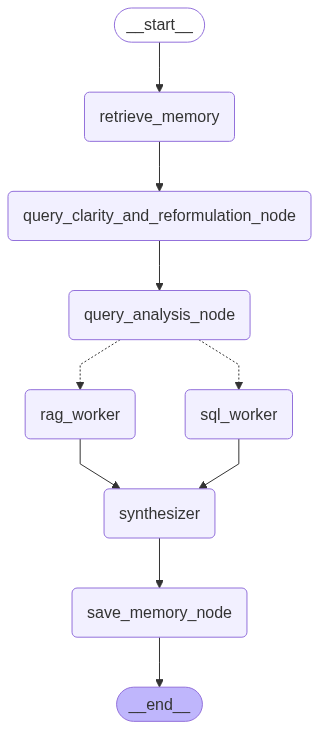

In [198]:
# Show the workflow
from IPython.display import Image, display
display(Image(rag_app.get_graph().draw_mermaid_png()))

In [199]:
config = {"configurable": { "user_id": '1', "thread_id": '1'}}

rag_app.invoke({
    "user_query": "Team Concept for Arch Insurance group? and state with the most litigation claims?"
}, config=config)


📚 Retrieving recent memory...
🧠 Retrieved 0 past memories
🧐 Checking query clarity and possibly reformulating...
🔍 Reformulation required: False
🔍 Running Query Analyzer Node
🧠 Subqueries extracted:
- [RAG] What is the team concept for Arch Insurance Group?
- [SQL] Which state has the most litigation claims?
📥 RAG Worker received query: What is the team concept for Arch Insurance Group?
🛠️ SQL Worker received query: Which state has the most litigation claims?
🧠 Synthesizing final output...
💾 Saving memory...
✅ Memory saved.


{'user_query': 'Team Concept for Arch Insurance group? and state with the most litigation claims?',
 'reformulated_query': 'Team Concept for Arch Insurance group? and state with the most litigation claims?',
 'reformulation_required': False,
 'subqueries': [SubQuery(query='What is the team concept for Arch Insurance Group?', intent='rag'),
  SubQuery(query='Which state has the most litigation claims?', intent='sql')],
 'rag_outputs': [Document(metadata={'filename': 'Arch-Lit Guidelines-2014.pdf'}, page_content='2                                                           LITIGATION GUIDELINES FOR DEFENSE AND COVERAGE COUNSEL 11/1/14  Team Concept  \nThe team concept is best implemented if the cases assigned b y Arch Insur ance are con sistently \nhandled by a core group of legal professionals in your office.  Optimally, each case should be \nhandled by one attorney who may, when appropriate, be assisted by an associate or paralegal.  \nWe expect counsel assigned to a  case will remain o

In [200]:
config = {"configurable": { "user_id": '1', "thread_id": '1'}}

rag_app.invoke({
    "user_query": "What's the state with the most litigation claims?"
}, config=config)


📚 Retrieving recent memory...
🧠 Retrieved 1 past memories
🧐 Checking query clarity and possibly reformulating...
🔍 Reformulation required: True
🔍 Running Query Analyzer Node
🧠 Subqueries extracted:
- [SQL] Which state has the highest number of litigation claims according to the data provided?
🛠️ SQL Worker received query: Which state has the highest number of litigation claims according to the data provided?
🧠 Synthesizing final output...
💾 Saving memory...
✅ Memory saved.


{'user_query': "What's the state with the most litigation claims?",
 'reformulated_query': 'Which state has the highest number of litigation claims according to the data provided?',
 'reformulation_required': True,
 'subqueries': [SubQuery(query='Which state has the highest number of litigation claims according to the data provided?', intent='sql')],
 'rag_outputs': [Document(metadata={'filename': 'Arch-Lit Guidelines-2014.pdf'}, page_content='2                                                           LITIGATION GUIDELINES FOR DEFENSE AND COVERAGE COUNSEL 11/1/14  Team Concept  \nThe team concept is best implemented if the cases assigned b y Arch Insur ance are con sistently \nhandled by a core group of legal professionals in your office.  Optimally, each case should be \nhandled by one attorney who may, when appropriate, be assisted by an associate or paralegal.  \nWe expect counsel assigned to a  case will remain on that case from start to finish unless \notherwise discussed.  As wi

In [202]:
config = {"configurable": { "user_id": '1', "thread_id": '1'}}

rag_app.invoke({
    "user_query": "What is litigation cost per litigation in Virginia ?"
}, config=config)


📚 Retrieving recent memory...
🧠 Retrieved 3 past memories
🧐 Checking query clarity and possibly reformulating...
🔍 Reformulation required: True
🔍 Running Query Analyzer Node
🧠 Subqueries extracted:
- [SQL] What is the average litigation cost per case in Virginia?
🛠️ SQL Worker received query: What is the average litigation cost per case in Virginia?
🧠 Synthesizing final output...
💾 Saving memory...
✅ Memory saved.


{'user_query': 'What is litigation cost per litigation in Virginia ?',
 'reformulated_query': 'What is the average litigation cost per case in Virginia, based on the available data?',
 'reformulation_required': True,
 'subqueries': [SubQuery(query='What is the average litigation cost per case in Virginia?', intent='sql')],
 'rag_outputs': [Document(metadata={'filename': 'Arch-Lit Guidelines-2014.pdf'}, page_content='2                                                           LITIGATION GUIDELINES FOR DEFENSE AND COVERAGE COUNSEL 11/1/14  Team Concept  \nThe team concept is best implemented if the cases assigned b y Arch Insur ance are con sistently \nhandled by a core group of legal professionals in your office.  Optimally, each case should be \nhandled by one attorney who may, when appropriate, be assisted by an associate or paralegal.  \nWe expect counsel assigned to a  case will remain on that case from start to finish unless \notherwise discussed.  As with all of these guidelines, 

In [204]:
config = {"configurable": { "user_id": '1', "thread_id": '1'}}

rag_app.invoke({
    "user_query": "Investigation for Arch Insurance ?"
}, config=config)


📚 Retrieving recent memory...
🧠 Retrieved 3 past memories
🧐 Checking query clarity and possibly reformulating...
🔍 Reformulation required: True
🔍 Running Query Analyzer Node
🧠 Subqueries extracted:
- [SQL] What investigations or audits are currently being conducted for Arch Insurance?
- [RAG] What details are available about the investigations or audits for Arch Insurance?
🛠️ SQL Worker received query: What investigations or audits are currently being conducted for Arch Insurance?
📥 RAG Worker received query: What details are available about the investigations or audits for Arch Insurance?
🧠 Synthesizing final output...
💾 Saving memory...
✅ Memory saved.


{'user_query': 'Investigation for Arch Insurance ?',
 'reformulated_query': 'What investigations or audits are currently being conducted for Arch Insurance, and what details are available about them?',
 'reformulation_required': True,
 'subqueries': [SubQuery(query='What investigations or audits are currently being conducted for Arch Insurance?', intent='sql'),
  SubQuery(query='What details are available about the investigations or audits for Arch Insurance?', intent='rag')],
 'rag_outputs': [Document(metadata={'filename': 'Arch-Lit Guidelines-2014.pdf'}, page_content='2                                                           LITIGATION GUIDELINES FOR DEFENSE AND COVERAGE COUNSEL 11/1/14  Team Concept  \nThe team concept is best implemented if the cases assigned b y Arch Insur ance are con sistently \nhandled by a core group of legal professionals in your office.  Optimally, each case should be \nhandled by one attorney who may, when appropriate, be assisted by an associate or paral